# Homework 7 - Logistic Regression, SVM, k-means, Gaussian Mixture Model

Make sure you have downloaded:
1. 'SpikeSorting.mat'
2. 'synthetic_spike_labels.csv'

## 0 Introduction and Loading of Data:

We revisit the spike data from previous section and homework. You may read those Jupyter notebooks for further introduction. 

Before performing clustering, we reduce the dimension of the data by projecting it to the first 2 principal components, and working in the principal component axes.

Run the following cells to load, visualize, and preprocess the data.

### Load data

In [1]:
# ------  DO NOT CHANGE CODE IN THIS CELL ------
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

mat = scipy.io.loadmat('SpikeSorting.mat')
spikes = np.squeeze(mat['spikes'])
voltages = np.squeeze(mat['voltage'])

n_spikes = len(spikes)

print(n_spikes)
print(voltages.shape)
# -----------------------------------------------

3298
(1440000,)


### Process data and visualize first 20 spikes
We store spike data as `X` and synthetically generated spike labels as `y`.

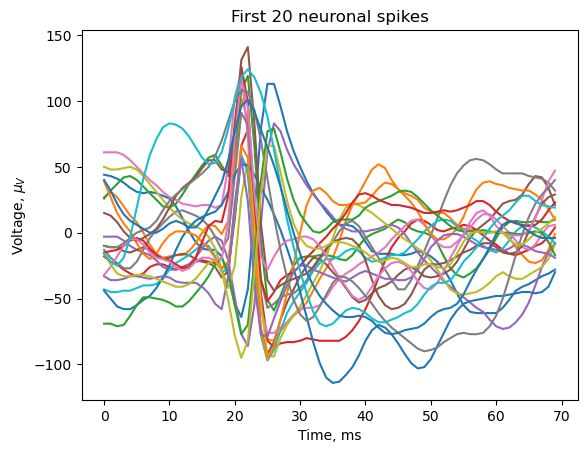

(3298, 70)
(3298,)


In [2]:
# ------  DO NOT CHANGE CODE IN THIS CELL ------
# process spike data
n_record_per_spike = 70 
X = np.zeros((n_spikes,n_record_per_spike))

for n in range(n_spikes):
    X[n,:] = voltages[spikes[n]: spikes[n] + n_record_per_spike]
    if n <= 20:
        plt.plot(np.arange(n_record_per_spike),X[n,:])

plt.xlabel(r'Time, ms'); plt.ylabel(r'Voltage, $\mu_V$'); 
plt.title('First 20 neuronal spikes'); plt.show()

# synthetic labels
y = np.loadtxt('synthetic_spike_labels.csv', delimiter=',')

print(X.shape)
print(y.shape)
# -----------------------------------------------

### Dimensionality Reduction with PCA

PCA has been applied to reduce the data from 70 dimensions to 2 dimensions, by choosing the largest 2 principal components.

(3298, 2)


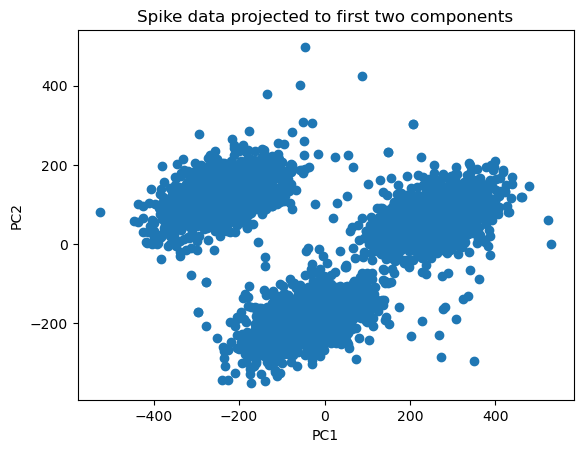

In [3]:
# ------  DO NOT CHANGE CODE IN THIS CELL ------
from sklearn.decomposition import PCA

model = PCA(n_components=2)
X = model.fit_transform(X)
print(X.shape)

plt.scatter(X[:,0], X[:,1])
plt.title('Spike data projected to first two components')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()
# -----------------------------------------------

## 1 (Supervised) Logistic Regession
### 1.1 Set up Pipeline and Gridsearch
**Task:**
1. [1 pt] Import `GridSearchCV`, `Pipeline`, and `StandardScaler`.
2. [2 pt] Write a function ```best(pipe, grid)```, which 
    - takes in a pipeline object ```pipe``` and dictionary of parameters ```grid``` to perform a grid search using GridSearchCV to find the optimal hyperparameters.
    - Use 3-fold cross-validation and set GridSearchCV scoring to "accuracy".
    - Use all data `X` and `y` as "training" data.
    - You can adapt it from section notebooks.

In [4]:
# TODO Packages: Grid Search, Pipeline, Scaling
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# TODO complete function
def best(pipe, grid):
    grid_search = GridSearchCV(pipe, grid, cv=3, scoring="accuracy")
    grid_search.fit(X, y)
    return grid_search.best_estimator_

### 1.2 Build Logistic Regression model
**Task:**
1. [3 pt] Use best() function to find the best logistic regression model, `lr_model`.
    - For the pipeline, include a standard scaler.
    - For the grid, set penalty = ('l2', 'l1'), solver = ['liblinear'], C = [1e-2, 1e-1, 1e0, 1e1, 1e2].
2. [1 pt] Print the best model.

In [5]:
from sklearn.linear_model import LogisticRegression

# TODO Logistic Regression with pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('logistic', LogisticRegression(solver='liblinear'))])
grid = {
    'logistic__penalty': ('l2', 'l1'), 
    'logistic__solver': ['liblinear'], 
    'logistic__C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
lr_model = best(pipe, grid)
print(lr_model)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic',
                 LogisticRegression(penalty='l1', solver='liblinear'))])


### 1.3 Set up plot function
**Task:**

Complete the function `plot_labels_and_decbdy(label, data, model, modelname)` that displays a scatter plot of data points with their labels and the decision boundary of the model.
- `label` is a vector of labels, whether it was given by training data or inferred via unsupervised clustering.
- `data` is the coordinate values of the features.
- `model` is the sklearn model object that you will use to generate the decision boundary.
- `modelname` is a string that will be used for your plot title.
1. [1 pt] Scatter plot of data with their labels.
2. [1 pt] Complete code for the meshgrid.
3. [1 pt] Compute predicted labels `pred` for each point on meshgrid, based on input model.
4. [1 pt] Make an informative title that uses the argument modelname.

In [6]:
def plot_labels_and_decbdy(label, data, model, modelname):
    # TODO scatter plot
    plt.scatter(data[:,0],data[:,1], c=label, cmap=plt.cm.gray)
    # TODO complete meshgrid
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    n_dec_bdy = 1000
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, n_dec_bdy),
    np.linspace(y_min, y_max, n_dec_bdy))
    # TODO labels for each point in meshgrid
    pred = model.predict(np.c_[xx.ravel(),yy.ravel()]).reshape(xx.shape)

    # Put the result into a color plot
    plt.imshow(pred, interpolation='nearest',
                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                cmap=plt.cm.Paired,
                aspect='equal', origin='lower', alpha=0.7)

    # TODO Make an informative title that uses the argument modelname
    plt.title(f"Decision Boundary for {modelname}")
    plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

### 1.4 Plot
**Task:**
1. [1 pt] Use `plot_labels_and_decbdy` to plot the data points, their labels, and the decision boundary of the logistic regression model.

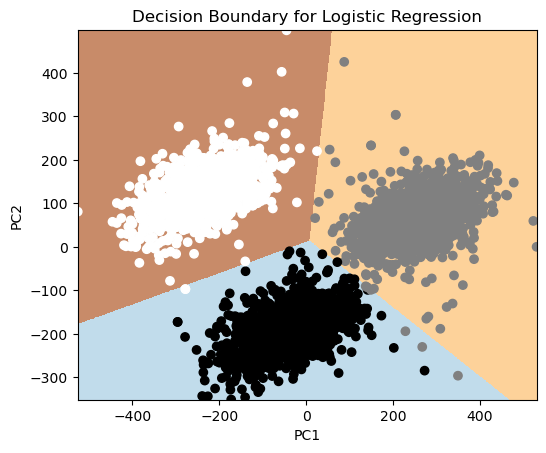

In [7]:
# TODO plot
plot_labels_and_decbdy(y, X, lr_model, "Logistic Regression")

## 2 (Supervised) Suppor Vector Machine
### 2.1 Build SVM model
**Task:**
1. [3 pt] Use best() function to find the best SVM model, `svm_model`.
    - For the pipeline, include a standard scaler.
    - For the grid, set kernel = ('rbf', 'sigmoid'), C = [1e-2, 1e-1, 1e0, 1e1, 1e2].
2. [1 pt] Print the best model.

In [8]:
from sklearn.svm import SVC
# TODO SVM with pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('svm', SVC())])
grid = {
    'svm__kernel': ('rbf', 'sigmoid'), 
    'svm__C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
svm_model = best(pipe, grid)
print(svm_model)

Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC())])


### 2.2 Plot
**Task:**
1. [1 pt] Use `plot_labels_and_decbdy` to plot the data points, their labels, and the decision boundary of the SVM model.

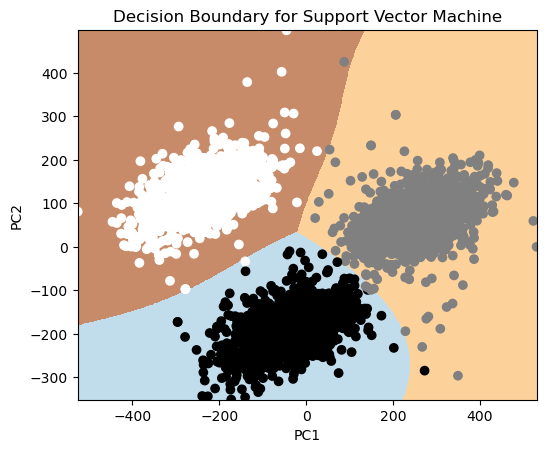

In [9]:
# TODO plot
plot_labels_and_decbdy(y, X, svm_model, "Support Vector Machine")

## 3 (Unsupervised) K means
### 3.1 Choose number of clusters via elbow plot
In the unsupervised setting, we do not have labels `y` anymore!

So, we need to identify how many clusters we want in the unsupervised model. Here is one way to do it.

**Task:**
1. Complete the code below.
    - [1 pt] Define `kmeans_mdl`. Set n_clusters = num_clusters, n_init=100, init='k-means++', random_state=0.
    - [1 pt] Fit kmeans_mdl to the data `X`.
2. [1 pt] Run the cell and produce the plot. 
3. [1 pt] What does the plot suggest about the correct number of clusters we should be using? Is that consistent with what you observed in the previous parts?
    
    **Ans:** (The correct number of clusters is 3, as observed in the previous parts. 3 is optimal since inertia stops steeply decreasing after 3 clusters. 4-7 clusters show very small improvement, hence unnecessary to continue.)

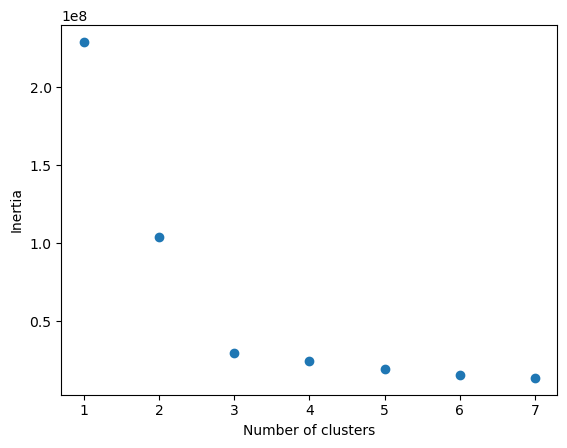

In [10]:
from sklearn.cluster import KMeans
klist = []
slist = []

for num_clusters in range(1,8):
    # TODO define k means and fit data
    kmeans_mdl = KMeans(n_clusters=num_clusters, init='k-means++', n_init=100, 
                        random_state=0)
    kmeans_mdl.fit(X)
    klist.append(num_clusters)
    slist.append(kmeans_mdl.inertia_)
plt.plot(klist,slist,'o')
plt.xlabel('Number of clusters'); plt.ylabel('Inertia'); plt.show()

### 3.2 Build k means model
**Task:**
1. [1 pt] Define `km_model`, the KMeans object 
    -   Set init = 'k-means++', n_clusters to what you inferred in the previous part, n_init = 100, random_state = 0.
2. [1 pt] Fit the model to the projected data.
3. [1 pt] Predict the clusters and store them as `Cpred_km`.

In [11]:
# TODO define, fit, and predict k means
km_mdl = KMeans(n_clusters=3, init='k-means++', n_init=100, random_state=0)
km_mdl.fit(X)
Cpred_km = km_mdl.predict(X)

### 3.3 Plot
Use the number of clusters you identified in the previous part.
1. [1 pt] Use `plot_labels_and_decbdy` to plot the data points, their labels, and the decision boundary of the k-means model.

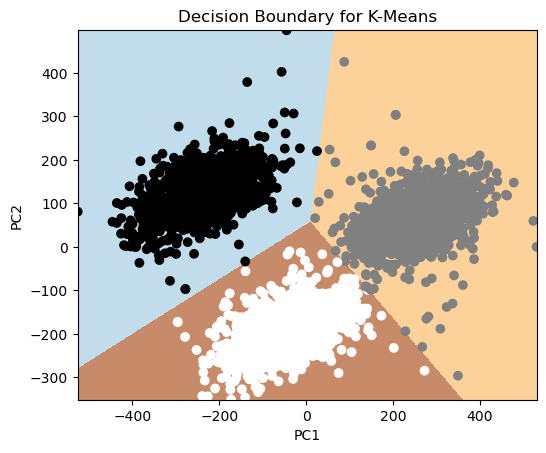

In [12]:
# TODO plot
plot_labels_and_decbdy(Cpred_km, X, km_mdl, "K-Means model")

## 4 (Unsupervised) Gaussian Mixture Models
### 4.1 Build GMM model

**Task:**
1. [1 pt] Define `gmm_model`, the GaussianMMixture object.
    - Set init n_components = 3.
2. [1 pt] Fit the model to the projected data.
3. [1 pt] Predict the clusters and store them as `Cpred_gmm`.

In [13]:
from sklearn.mixture import GaussianMixture

# TODO define, fit, and predict GMM
gmm_model = GaussianMixture(n_components=3)
gmm_model.fit(X)
Cpred_gmm = gmm_model.predict(X)

### 4.2 Plot
1. [1 pt] Use `plot_labels_and_decbdy` to plot the data points, their labels, and the decision boundary of the GMM model.

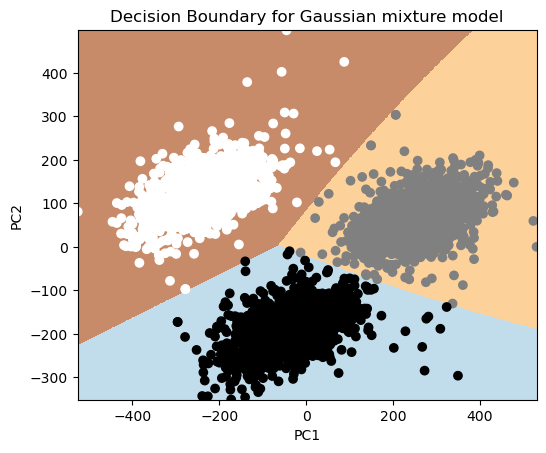

In [14]:
# TODO plot
plot_labels_and_decbdy(Cpred_gmm, X, gmm_model, "Gaussian mixture model")

## 5 Discussion
1. [1 pt] What is a key difference between the process of supervised learning (logistic regression/SVM) and unsupervised learning (k-means/GMM)? Your response should be related to the (un)supervised-ness of the approaches. We are looking for evidence that you are genuinely reflecting on the paradigms of these approaches, 1-2 sentences are enough.
    
    **Ans:** Supervised learning its dataset paired with a pre-defined label. The learning aims to predict the label based on the input features. Unsupervised learning has no labels in the dataset; the goal is to discover inherent patterns like clustering just from the samples. Unlike supervised ones, it has no clue on the result.